# **City of Cleveland - Crime Offense Analysis**

## **Resources**
- https://data.clevelandohio.gov/datasets/ClevelandGIS::crime-incidents/about

In [80]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import HeatMap
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Ensure environment variables are loaded correctly
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# Connect to PostgreSQL using psycopg2
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Use a cursor to execute the query
query = "SELECT * FROM crime_data;"
with conn.cursor() as cursor:
    cursor.execute(query)
    crime_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])



# Display first rows
crime_df.head()




,objectid,primarykey,casenumber,district,ucrdesc,offenseyear,timegroup,reporteddate,offensemonth,offenseday,...,ward,city,census_tract,census_tract_geoid,census_block_group,census_bg_geoid,census_block,census_block_geoid,lat,lon
0,62683,202200174953001,2022-00174953,District 4,All Other Offenses,2022,Older,2022-06-20 20:54:00,6,20,...,Ward 2,cleveland,Census Tract 1158,39035115800,Block Group 3,390351158003,Block 3000,390351158003000,41.444057,-81.625034
1,62684,202200175020001,2022-00175020,District 4,GTMV,2022,Older,2022-06-20 22:10:00,6,20,...,Ward 6,cleveland,Census Tract 1986,39035198600,Block Group 2,390351986002,Block 2002,390351986002002,41.489121,-81.614102
2,62685,202200175049001,2022-00175049,District 1,Theft,2022,Older,2022-06-20 22:35:00,6,20,...,Ward 16,cleveland,Census Tract 1235.01,39035123501,Block Group 3,390351235013,Block 3001,390351235013001,41.468992,-81.772681
3,62686,202200175081001,2022-00175081,District 4,Assault,2022,Older,2022-06-20 23:07:00,6,20,...,Ward 4,cleveland,Census Tract 1202,39035120200,Block Group 3,390351202003,Block 3006,390351202003006,41.472486,-81.620283
4,62687,202200175128001,2022-00175128,District 3,Vandalism,2022,Older,2022-06-20 23:49:00,6,19,...,Ward 7,cleveland,Census Tract 1084,39035108400,Block Group 1,390351084001,Block 1004,390351084001004,41.512345,-81.659245


## **Crime Trends & Patterns**

**Yearly Crime Trends**

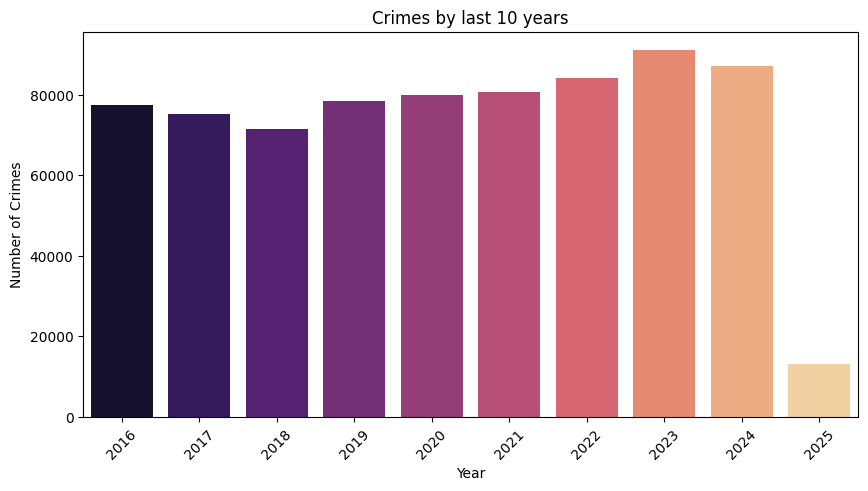

In [81]:
# Aggregate crime count by year
crime_by_year = crime_df.groupby("offenseyear").size().reset_index(name="crime_count")

# Sort by highest crime
crime_by_year = crime_by_year.sort_values(by="crime_count", ascending=False).head(10)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=crime_by_year["offenseyear"], y=crime_by_year["crime_count"], palette="magma")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Crimes by last 10 years")
plt.xticks(rotation=45)
plt.show()

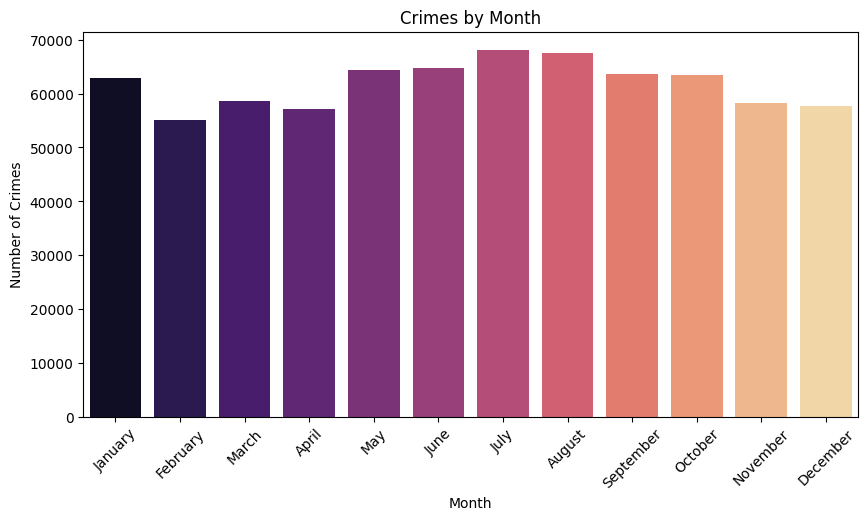

In [82]:
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
} 

# Map month numbers to month names  
crime_df["month"] = crime_df["offensemonth"].map(months)

# Create plot that shows the number of crimes per month
plt.figure(figsize=(10, 5))
sns.countplot(x="month", data=crime_df, palette="magma", order=months.values())
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.title("Crimes by Month")
plt.xticks(rotation=45) # Rotate x-axis labels
plt.show()



Text(0.5, 1.0, 'Crimes by Hour')

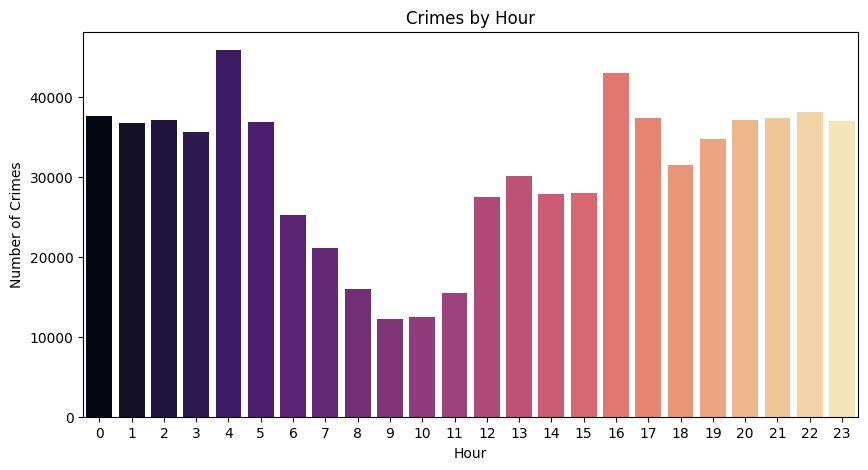

In [83]:
#Time of day analysis for offensedate
# Extract the hour from the offensedate column
crime_df["hour"] = crime_df["offensedate"].dt.hour

# Create a plot that shows the number of crimes per hour
plt.figure(figsize=(10, 5))
sns.countplot(x="hour", data=crime_df, palette="magma")
plt.xlabel("Hour")
plt.ylabel("Number of Crimes")
plt.title("Crimes by Hour")


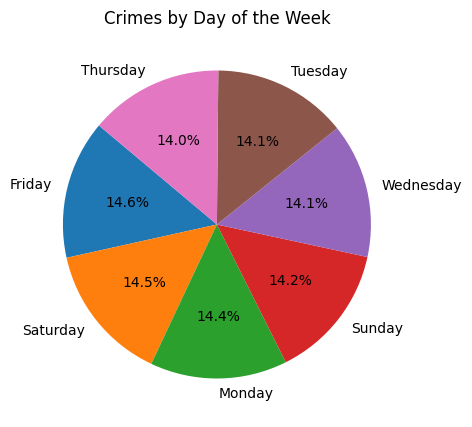

In [84]:
# Query to get crime counts per ward
query = """
SELECT downame, COUNT(*) AS total_offenses
FROM crime_data
WHERE downame IS NOT NULL
GROUP BY downame
ORDER BY total_offenses DESC, downame
LIMIT 10;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    crime_by_dow = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Plot the Pie Chart
plt.figure(figsize=(10, 5))
plt.pie(crime_by_dow["total_offenses"], labels=crime_by_dow["downame"], autopct="%1.1f%%", startangle=140)
plt.title("Crimes by Day of the Week")
plt.show()


### **Geospatial Crime Analysis**

**Crimes by Ward**

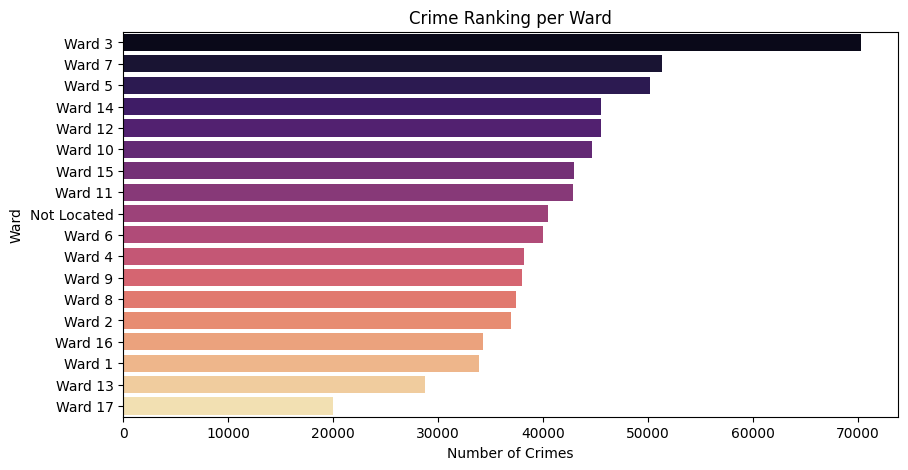

In [85]:
# Query to get crime counts per ward
query = """
SELECT ward, COUNT(*) AS crime_count
FROM crime_data
WHERE ward IS NOT NULL
GROUP BY ward
ORDER BY crime_count DESC;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    crime_by_ward = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Convert ward column to string (for proper sorting)
crime_by_ward["ward"] = crime_by_ward["ward"].astype(str)

# Create the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(y=crime_by_ward["ward"], x=crime_by_ward["crime_count"], palette="magma")

# Add labels and title
plt.xlabel("Number of Crimes")
plt.ylabel("Ward")
plt.title("Crime Ranking per Ward")
plt.show()



# Cities with the most offenses

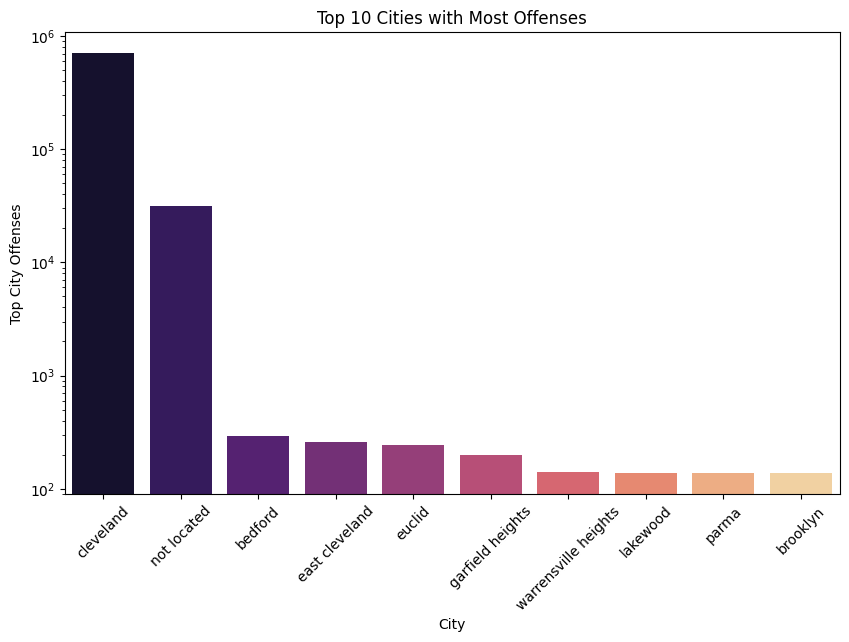

In [86]:
# Query to get crime counts per city
query = """
SELECT TRIM(LOWER(city)) AS city, COUNT(*) AS total_offenses
FROM crime_data
WHERE city IS NOT NULL AND city != 'Not Located'
GROUP BY TRIM(LOWER(city))
ORDER BY total_offenses DESC
LIMIT 10;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(query)
    top_cities_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(y=top_cities_df["total_offenses"], x=top_cities_df["city"], palette="magma")

# Add labels and title
plt.xlabel("City")
plt.ylabel("Top City Offenses")
plt.title("Top 10 Cities with Most Offenses")
plt.yscale("log")
plt.xticks(rotation=45)
plt.show()




#City with the least offenses

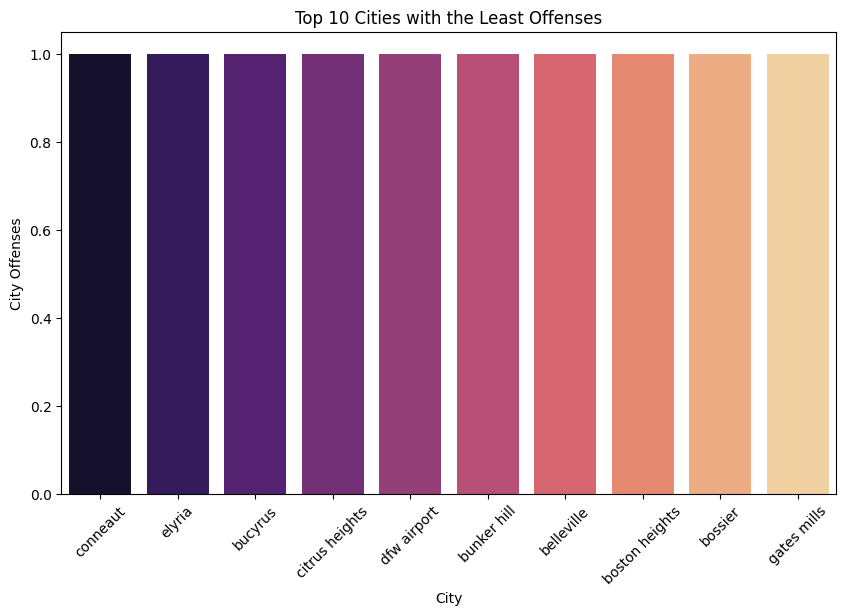

In [87]:
# Query to get crime counts per city (for cities with only alphabetic names, length > 3)
query = """
SELECT TRIM(LOWER(city)) AS city, COUNT(*) AS total_offenses
FROM crime_data
WHERE city IS NOT NULL 
AND city != 'Not Located'
AND city !~ '[^a-zA-Z ]'  -- Ensures only alphabetic city names
AND LENGTH(city) > 3      -- Filters out short names
GROUP BY TRIM(LOWER(city))
ORDER BY total_offenses ASC
LIMIT 10;
"""

# Fetch data manually to avoid Pandas SQLAlchemy warning
with conn.cursor() as cursor:
    cursor.execute(query)
    top_cities_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(y=top_cities_df["total_offenses"], x=top_cities_df["city"], palette="magma")

# Add labels and title
plt.xlabel("City")
plt.ylabel("City Offenses")
plt.title("Top 10 Cities with the Least Offenses")
plt.yscale("linear")
plt.xticks(rotation=45)
plt.show()



**Crimes by District**

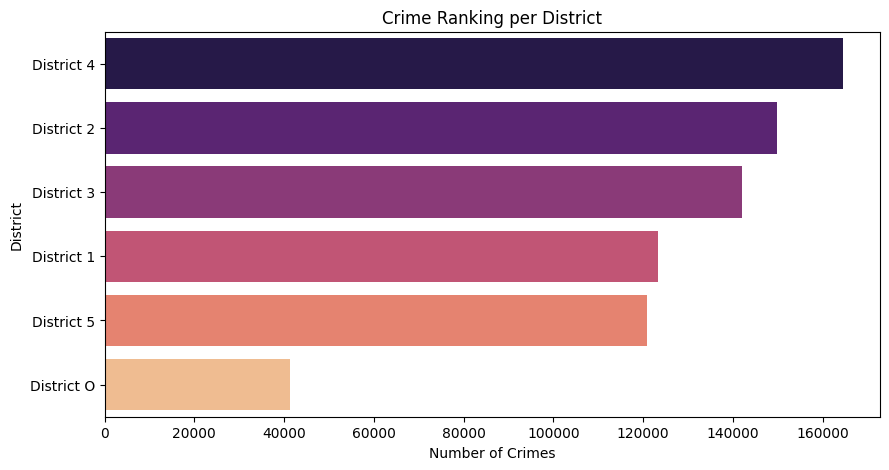

In [88]:
# Query to get crime counts per district
query = """
SELECT district, COUNT(*) AS crime_count
FROM crime_data
WHERE district IS NOT NULL
GROUP BY district
ORDER BY crime_count DESC;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(query)
    crime_by_district = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Convert district column to string (for proper sorting)
crime_by_district["district"] = crime_by_district["district"].astype(str)

# Create the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(y=crime_by_district["district"], x=crime_by_district["crime_count"], palette="magma")

# Add labels and title
plt.xlabel("Number of Crimes")
plt.ylabel("District")
plt.title("Crime Ranking per District")
plt.show()


## **Crime Type Analysis**

**Type of Crime**

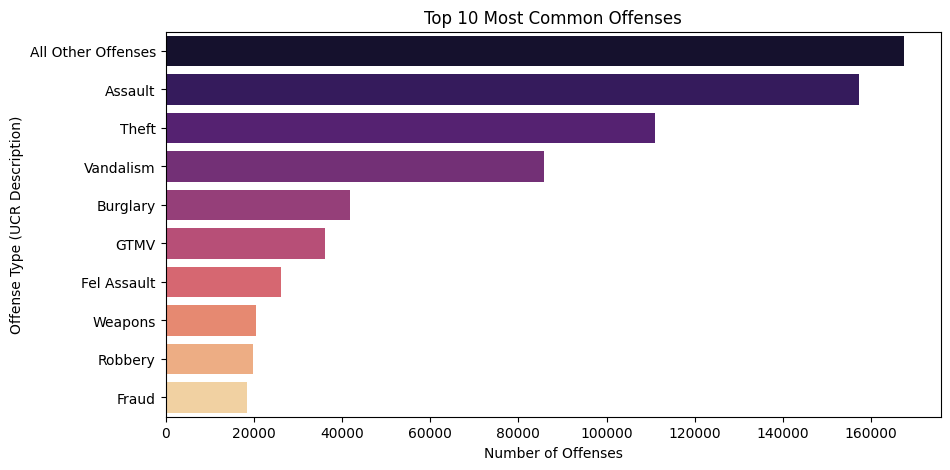

In [89]:
# Query to get crime counts per offense description (UCR Desc)
query = """
SELECT ucrdesc, COUNT(*) AS offense_count
FROM crime_data
WHERE ucrdesc IS NOT NULL
GROUP BY ucrdesc
ORDER BY offense_count DESC;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(query)
    crime_by_ucrdesc = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Create the bar chart (Top 10 offenses)
plt.figure(figsize=(10, 5))
sns.barplot(y=crime_by_ucrdesc["ucrdesc"].head(10), x=crime_by_ucrdesc["offense_count"], palette="magma")

# Add labels and title
plt.xlabel("Number of Offenses")
plt.ylabel("Offense Type (UCR Description)")
plt.title("Top 10 Most Common Offenses")
plt.show()


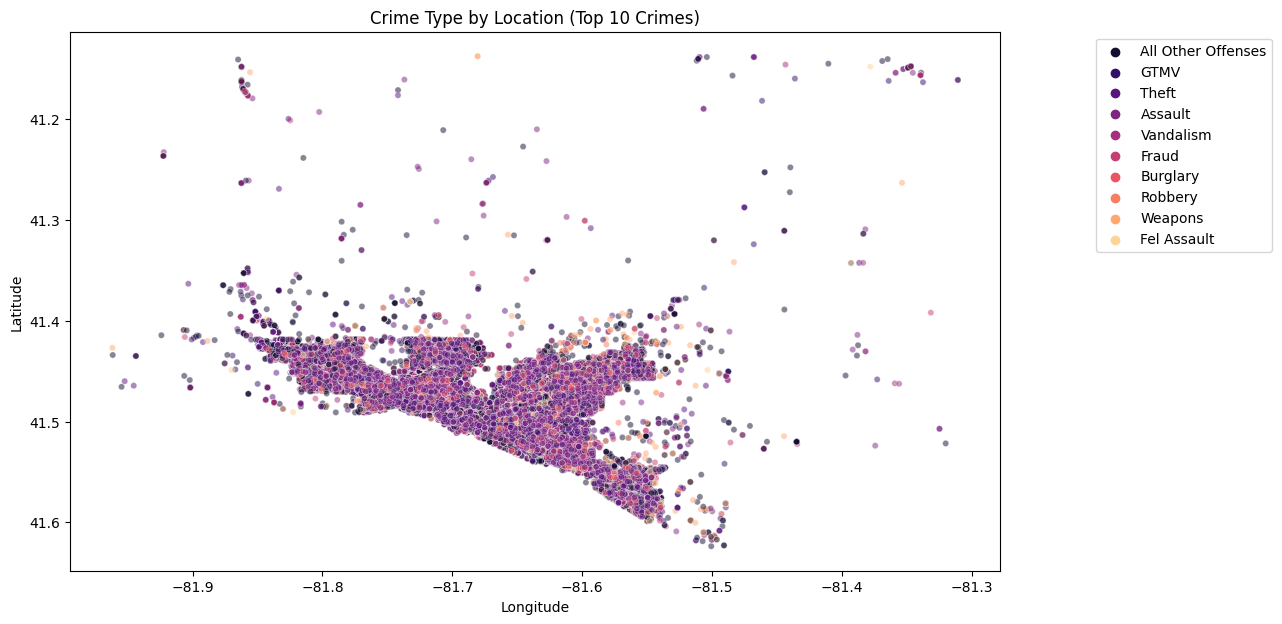

In [90]:

top_crimes = crime_df["ucrdesc"].value_counts().index[:10]
filtered_df = crime_df[crime_df["ucrdesc"].isin(top_crimes)]

plt.figure(figsize=(12, 7))
sns.scatterplot(data=filtered_df, x="lon", y="lat", hue="ucrdesc", palette="magma", alpha=0.5, s=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Crime Type by Location (Top 10 Crimes)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()

## Additional Insights

How long does it take a crime to be reported from when it occured?

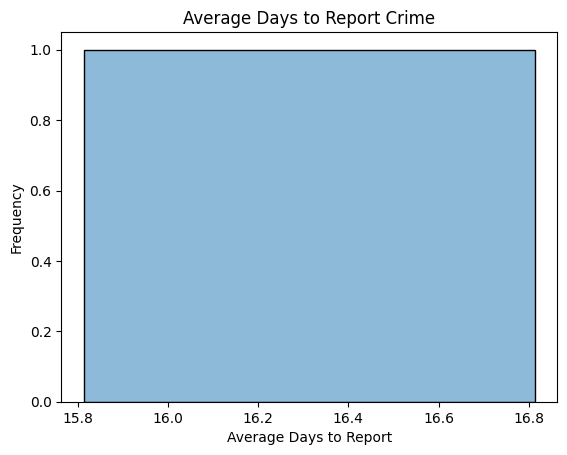

In [92]:
# Query to get average days between offense and report
df_query = """
SELECT AVG(EXTRACT(EPOCH FROM reporteddate - offensedate) / 86400) AS avg_days_to_report
FROM crime_data
WHERE offensedate IS NOT NULL AND reporteddate IS NOT NULL 
AND offensedate <= reporteddate;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(df_query)
    avg_report_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Plot the histogram
sns.histplot(avg_report_df["avg_days_to_report"], kde=True)
plt.xlabel("Average Days to Report")        
plt.ylabel("Frequency")
plt.title("Average Days to Report Crime")
plt.show()



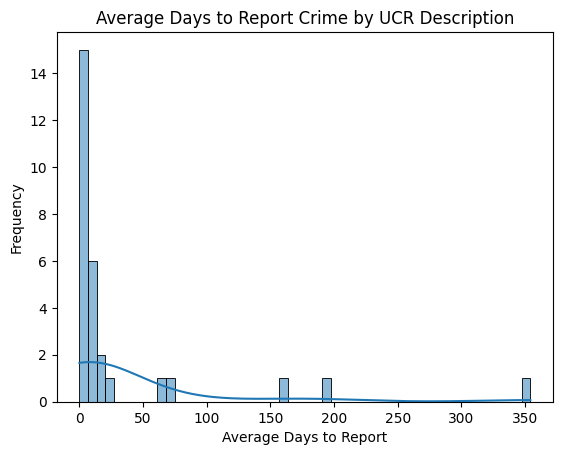

In [93]:
# Query to get average days between offense and report per UCR description
df_query = """
SELECT ucrdesc, AVG(EXTRACT(EPOCH FROM reporteddate - offensedate) / 86400) AS avg_days_to_report
FROM crime_data
WHERE offensedate IS NOT NULL AND reporteddate IS NOT NULL 
AND offensedate <= reporteddate
GROUP BY ucrdesc;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(df_query)
    avg_report_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Plot the histogram
sns.histplot(avg_report_df["avg_days_to_report"], kde=True)
plt.xlabel("Average Days to Report")        
plt.ylabel("Frequency")
plt.title("Average Days to Report Crime by UCR Description")   
plt.show()
 


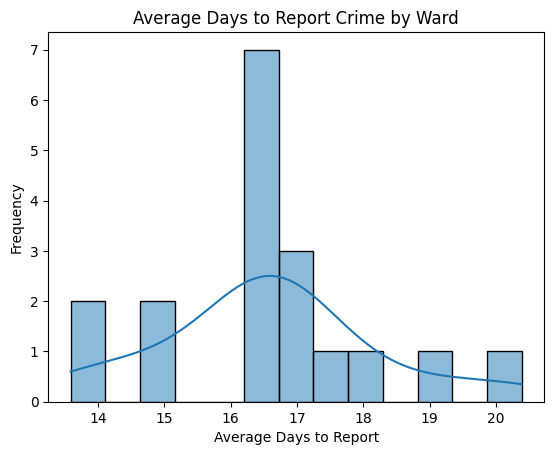

In [94]:
# Query to get average days between offense and report per ward
df_query = """
SELECT ward, AVG(EXTRACT(EPOCH FROM reporteddate - offensedate) / 86400) AS avg_days_to_report
FROM crime_data
WHERE offensedate IS NOT NULL AND reporteddate IS NOT NULL 
AND offensedate <= reporteddate
GROUP BY ward;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(df_query)
    avg_report_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Plot the histogram
sns.histplot(avg_report_df["avg_days_to_report"], kde=True)
plt.xlabel("Average Days to Report")        
plt.ylabel("Frequency")
plt.title("Average Days to Report Crime by Ward")   
plt.show()
 


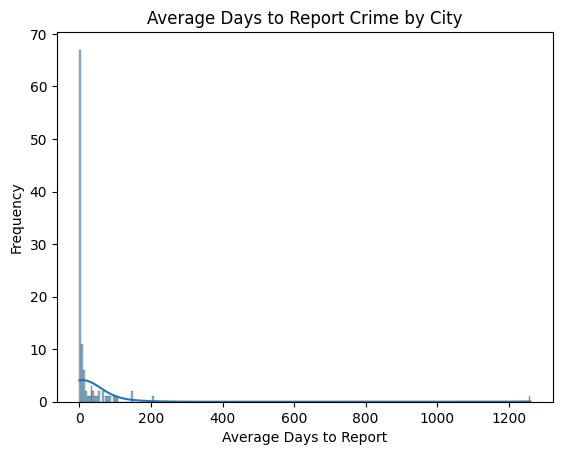

In [95]:
# Query to get average days between offense and report per city
df_query = """
SELECT city, AVG(EXTRACT(EPOCH FROM reporteddate - offensedate) / 86400) AS avg_days_to_report
FROM crime_data
WHERE offensedate IS NOT NULL AND reporteddate IS NOT NULL 
AND offensedate <= reporteddate
GROUP BY city;
"""

# Fetch data using a cursor (Prevents SQLAlchemy Warning)
with conn.cursor() as cursor:
    cursor.execute(df_query)
    avg_report_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Plot the histogram
sns.histplot(avg_report_df["avg_days_to_report"], kde=True)
plt.xlabel("Average Days to Report")        
plt.ylabel("Frequency")
plt.title("Average Days to Report Crime by City")   
plt.show()
 
